In [18]:
##############################
# Solves -u'' + u = f        #
# With zero Neumann boundary #
##############################
import radiant as rad
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['legend.fontsize'] = 'large'


# Problem Parameters
a = 0.
b = 1.


def exact(*x):
    return np.prod(np.cos(np.asarray(x) * 2 * np.pi / (b - a)), axis=0)


def f(*x):
    return (len(x) * (2 * np.pi / (b - a)) ** 2 + 1) * exact(*x)

In [19]:
# Parameters
d = 1
k = 2
inner = 5
outer = 3
start_delta = 2.
start_N = 3

# Computed Parameters
ranges = ((a, b),) * d
centre_thinning = 2 ** np.arange(inner)
delta_thinning = 2 ** np.arange(inner)
xcs = [rad.gridinc(ranges, inc, flat=True) for inc in (b - a) / (centre_thinning * start_N)]
deltas = start_delta / delta_thinning

# Integration
# integrator = rad.integrate.MeanIntegrator(ranges, 2500)
integrator = rad.integrate.QuadIntegrator(ranges)
error_integrator = rad.integrate.QuadIntegrator(ranges)

# Solve for approximate solution
phis = [rad.Wendland(d, k, delta, xc) for delta, xc in zip(deltas, xcs)]
solver = rad.solve.MultilevelSolver(phis, rad.solve.GalerkinSolver, integrator, 'helmholtz', outer=outer)
approx = solver.solve(f)
error = rad.error(exact, approx, error_integrator)

print("L2 Relative Error:", error)
print("Condition Numbers:", solver.cond())

L2 Relative Error: 0.0369255049525718
Condition Numbers: [434.7013306205413, 5355.298393343062, 26085.98636024508, 51413.64952106126, 74025.52825380012]


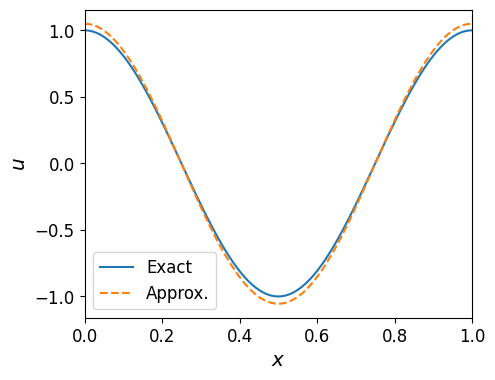

In [20]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.margins(x=0.)

x = rad.gridn(ranges, 200)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$u$')
ax.plot(*x, exact(*x), label="Exact")
ax.plot(*x, approx(*x), '--', label="Approx.")
plt.legend()

plt.savefig("figures/multilevel/galerkin/results.pdf", bbox_inches="tight")

In [21]:
short_idxs = range(1, inner + 1)
long_idxs = range(1, inner * outer + 1)
long_idxs_correct = list(short_idxs) * outer

errors = [rad.error(exact, approx[:i], error_integrator) for i in long_idxs]
conds = solver.cond()
bws = list(map(np.max, solver.bandwidth()))

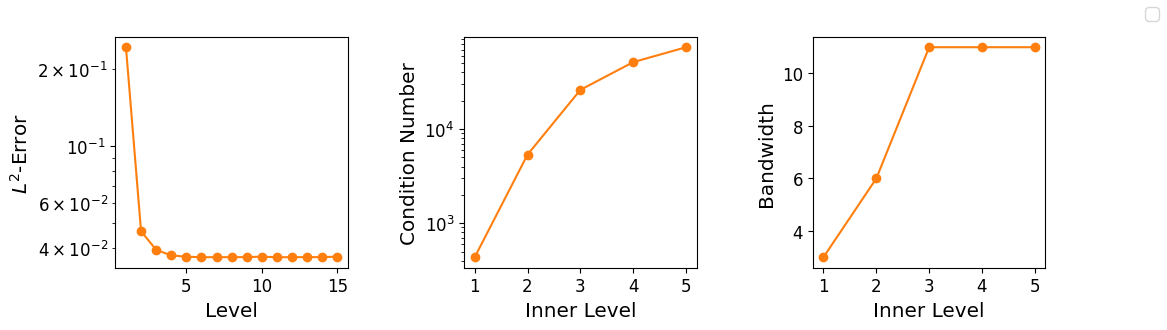

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].set_xlabel(r"Level")
axs[0].set_ylabel(r"$L^{2}$-Error")
axs[0].set_yscale('log')
axs[0].plot(long_idxs, errors, 'o-', color='C1')

axs[1].set_xlabel(r"Inner Level")
axs[1].set_ylabel("Condition Number")
axs[1].set_yscale('log')
axs[1].set_xticks(short_idxs)
axs[1].plot(short_idxs, conds, 'o-', color='C1')

axs[2].set_xlabel(r"Inner Level")
axs[2].set_ylabel("Bandwidth")
axs[2].set_xticks(short_idxs)
axs[2].plot(short_idxs, bws, 'o-', color='C1')

handles, labels = axs.flat[0].get_legend_handles_labels()
fig.legend(handles, labels)
plt.subplots_adjust(wspace=0.5)
plt.savefig("figures/multilevel/galerkin/data.pdf", bbox_inches="tight")